In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import os
import cv2
from albumentations import Compose, HorizontalFlip, RandomBrightnessContrast, Rotate, Resize
from albumentations.pytorch import ToTensorV2
import random


In [58]:
def count_images_per_class(base_folder):
    class_counts = {}
    # Include multiple image file extensions
    image_extensions = ('.png')

    # Iterate over each directory in the base folder
    for class_id in os.listdir(base_folder):
        class_path = os.path.join(base_folder, class_id)
        if os.path.isdir(class_path):
            # Count only image files in the directory
            count = len([name for name in os.listdir(class_path) 
                         if name.lower().endswith(image_extensions)])
            class_counts[class_id] = count

    # Directly return the maximum number of images across all classes
    return max(class_counts.values(), default=0)  # Returns 0 if no images or classes are found

In [59]:
train_input_path = 'data/Train'
max_images = count_images_per_class(train_input_path)

In [60]:
print(max_images)

2250


In [70]:
def get_augmentation_pipeline():
    return Compose([
        Resize(416, 416),
        HorizontalFlip(p=0.5),
        Rotate(limit=20),
        RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2)
    ])


In [72]:
def balance_classes_with_augmentation(input_path, output_path, transform, target_count,csv_output_path):
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    data_for_csv = []

    for folder in os.listdir(input_path):
        folder_path = os.path.join(input_path, folder)
        save_folder = os.path.join(output_path, folder)
        if not os.path.exists(save_folder):
            os.makedirs(save_folder)

        images = os.listdir(folder_path)
        current_count = len(images)
        augmentation_factor = target_count - current_count

        for image_file in images:
            original_image_path = os.path.join(folder_path, image_file)
            original_image = cv2.imread(original_image_path)
            original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
            resized_image = transform(image=original_image)['image']
            resized_image_path = os.path.join(save_folder, image_file)
            cv2.imwrite(resized_image_path, cv2.cvtColor(resized_image, cv2.COLOR_RGB2BGR))

            data_for_csv.append({
                "ClassId": folder,
                "Path": os.path.join(folder, image_file)
            })

        if augmentation_factor > 0:
            for i in range(augmentation_factor):
                # Randomly pick an image to augment
                image_file = random.choice(images)
                image_path = os.path.join(folder_path, image_file)
                image = cv2.imread(image_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                # Apply augmentation
                augmented = transform(image=image)
                augmented_image = augmented['image']

                # Save the augmented image with a unique name to avoid overwriting
                augmented_file_name = f"aug_{current_count + i}_{image_file}"
                save_path = os.path.join(save_folder, augmented_file_name)
                cv2.imwrite(save_path, cv2.cvtColor(augmented_image, cv2.COLOR_RGB2BGR))

                data_for_csv.append({
                    "ClassId": folder,
                    "Path": os.path.join(folder, augmented_file_name)
                })

        df = pd.DataFrame(data_for_csv)
        df.to_csv(csv_output_path, index=False)

# Calculate the new target count based on the maximum in the original dataset

# Adjust the target_count in the function call to match this new max_images


In [73]:
# Execute the balancing operation

augment_transform = get_augmentation_pipeline()
train_output_path = 'data/Augmented_Balanced_Train'
csv_output_path = 'data/aug_train.csv'
balance_classes_with_augmentation(train_input_path, train_output_path,augment_transform, max_images, csv_output_path)



In [74]:
# Function to count images in each folder
def count_images_in_folders(path):
    folders = [f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f))]
    image_counts = {folder: len(os.listdir(os.path.join(path, folder))) for folder in folders}
    sorted_image_counts = dict(sorted(image_counts.items(), key=lambda x: int(x[0])))
    return sorted_image_counts

# Count images in original and augmented datasets
original_image_counts = count_images_in_folders(train_input_path)
augmented_image_counts = count_images_in_folders(train_output_path)


In [75]:
print(original_image_counts)
print(augmented_image_counts)

{'0': 210, '1': 2220, '2': 2250, '3': 1410, '4': 1980, '5': 1860, '6': 420, '7': 1440, '8': 1410, '9': 1470, '10': 2010, '11': 1320, '12': 2100, '13': 2160, '14': 780, '15': 630, '16': 420, '17': 1110, '18': 1200, '19': 210, '20': 360, '21': 330, '22': 390, '23': 510, '24': 270, '25': 1500, '26': 600, '27': 240, '28': 540, '29': 270, '30': 450, '31': 780, '32': 240, '33': 689, '34': 420, '35': 1200, '36': 390, '37': 210, '38': 2070, '39': 300, '40': 360, '41': 240, '42': 240}
{'0': 2250, '1': 2250, '2': 2250, '3': 2250, '4': 2250, '5': 2250, '6': 2250, '7': 2250, '8': 2250, '9': 2250, '10': 2250, '11': 2250, '12': 2250, '13': 2250, '14': 2250, '15': 2250, '16': 2250, '17': 2250, '18': 2250, '19': 2250, '20': 2250, '21': 2250, '22': 2250, '23': 2250, '24': 2250, '25': 2250, '26': 2250, '27': 2250, '28': 2250, '29': 2250, '30': 2250, '31': 2250, '32': 2250, '33': 2250, '34': 2250, '35': 2250, '36': 2250, '37': 2250, '38': 2250, '39': 2250, '40': 2250, '41': 2250, '42': 2250}


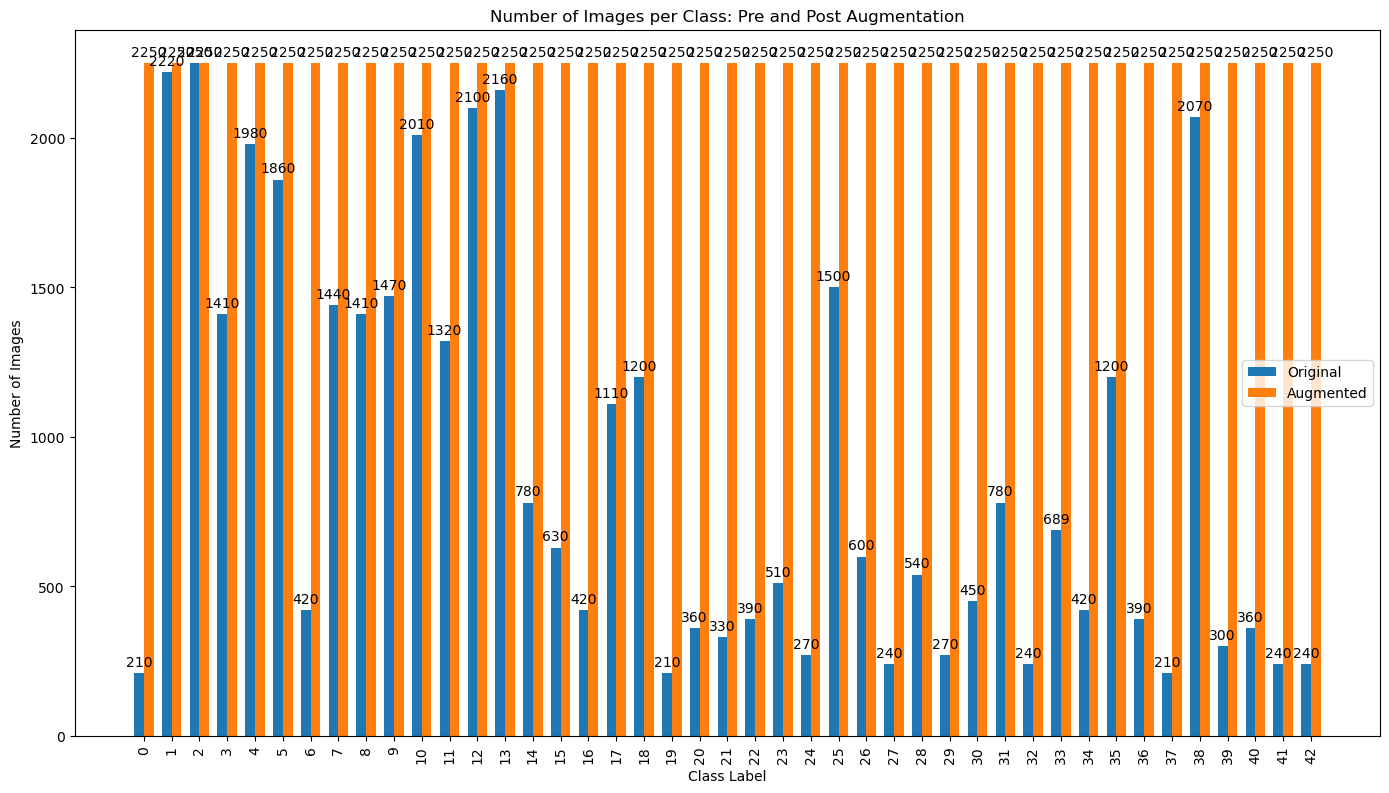

In [76]:
import matplotlib.pyplot as plt
import numpy as np

# Set up data for plotting
labels = list(original_image_counts.keys())
original_counts = [original_image_counts[label] for label in labels]
augmented_counts = [augmented_image_counts.get(label, 0) for label in labels]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(14, 8))
rects1 = ax.bar(x - width/2, original_counts, width, label='Original')
rects2 = ax.bar(x + width/2, augmented_counts, width, label='Augmented')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Class Label')
ax.set_ylabel('Number of Images')
ax.set_title('Number of Images per Class: Pre and Post Augmentation')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.xticks(rotation=90)
plt.show()
